In [ ]:
import marimo as mo
import numpy as np
import matplotlib.pyplot as plt
from pathlib import Path
from PIL import Image
import torch
import torch.nn as nn
import subprocess, random, io, base64

# Supervised learning: 🐱 or 🐶?

This notebook demonstrates **supervised learning** with a simple binary
classifier trained on real cat and dog photos. We download a public dataset,
resize the images, extract pixel features, and train a logistic regression
model with `PyTorch` to tell cats from dogs.

## Download the dataset

In [ ]:
DATA_DIR = Path("dog-cat-full-dataset/data")
download_dataset(DATA_DIR)
mo.md(f"Dataset ready at `{DATA_DIR}`")

Cloning into 'dog-cat-full-dataset'...
Updating files: 100% (24990/24990), done.


Dataset ready at `dog-cat-full-dataset/data`

## Load and preprocess images

In [ ]:
IMG_SIZE = 64
LABEL_NAMES = {0: "Cat", 1: "Dog"}

In [ ]:
train_images, train_labels, test_images, test_labels = load_dataset(
    DATA_DIR,
    IMG_SIZE,
    train_per_class=5000,
    test_per_class=500,
)

mo.md(
    f"Loaded **{len(train_images)}** training images and "
    f"**{len(test_images)}** test images "
    f"(resized to {IMG_SIZE}x{IMG_SIZE} RGB)."
)

Loaded **10000** training images and **1000** test images (resized to 64x64 RGB).

### Sample images from the dataset

Cat Cat Cat Cat Dog Dog Dog Dog
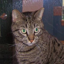
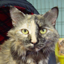
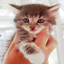
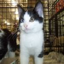
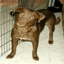
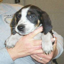
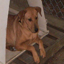
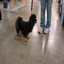

In [ ]:
_cat_indices = [i for i, l in enumerate(train_labels) if l == 0][:4]
_dog_indices = [i for i, l in enumerate(train_labels) if l == 1][:4]


def _make_card(idx, label_text):
    src = img_to_data_uri(train_images[idx])
    return mo.md(
        f"**{label_text}**<br/><img src='{src}' width='120' height='120' style='image-rendering:auto'/>"
    )


_cats = [_make_card(i, "Cat") for i in _cat_indices]
_dogs = [_make_card(i, "Dog") for i in _dog_indices]
mo.hstack(_cats + _dogs, justify="start", gap=1)

## Train the classifier

The model minimizes the **binary cross-entropy loss** over the training set:

$$\mathcal{L} = -\frac{1}{N}\sum_{i=1}^{N} \left[ y_i \log(\hat{p}_i) + (1 - y_i) \log(1 - \hat{p}_i) \right]$$

| Symbol | Meaning | In this task |
|--------|---------|--------------|
| $N$ | Number of training samples | 10,000 images (5,000 cats + 5,000 dogs) |
| $y_i$ | Ground-truth label for sample $i$ | 0 = Cat, 1 = Dog |
| $\mathbf{x}_i$ | Feature vector for sample $i$ | 12,288-dim vector (64 × 64 × 3 RGB pixels) |
| $\hat{p}_i = \sigma(\mathbf{w}^\top \mathbf{x}_i + b)$ | Predicted probability that sample $i$ is a dog | Model's confidence the photo is a dog |

When the true label is dog ($y_i = 1$), only the $\log(\hat{p}_i)$ term is active, penalizing low confidence. When the true label is cat ($y_i = 0$), only the $\log(1 - \hat{p}_i)$ term is active, penalizing high confidence. SGD adjusts $\mathbf{w}$ and $b$ to minimize $\mathcal{L}$.

In [ ]:
model = train_model(train_images, train_labels)
train_acc = evaluate(model, train_images, train_labels)
test_acc = evaluate(model, test_images, test_labels)

mo.md(
    f"""
    | Metric | Value |
    |--------|-------|
    | Training samples | {len(train_images)} |
    | Test samples | {len(test_images)} |
    | Features per image | {train_images[0].size} |
    | Epochs | 100 |
    | Train accuracy | {train_acc:.1%} |
    | **Test accuracy** | **{test_acc:.1%}** |
    """
)

| Metric | Value |
|--------|-------|
| Training samples | 10000 |
| Test samples | 1000 |
| Features per image | 12288 |
| Epochs | 100 |
| Train accuracy | 68.2% |
| **Test accuracy** | **61.1%** |

## Interactive predictions

In [ ]:
source_selector = mo.ui.dropdown(
    options=["Test set", "Training set"],
    value="Test set",
    label="Source",
)
sample_button = mo.ui.run_button(label="Sample random image")
mo.hstack([source_selector, sample_button], justify="start", gap=1)

True label: Cat | Predicted: Dog | Incorrect
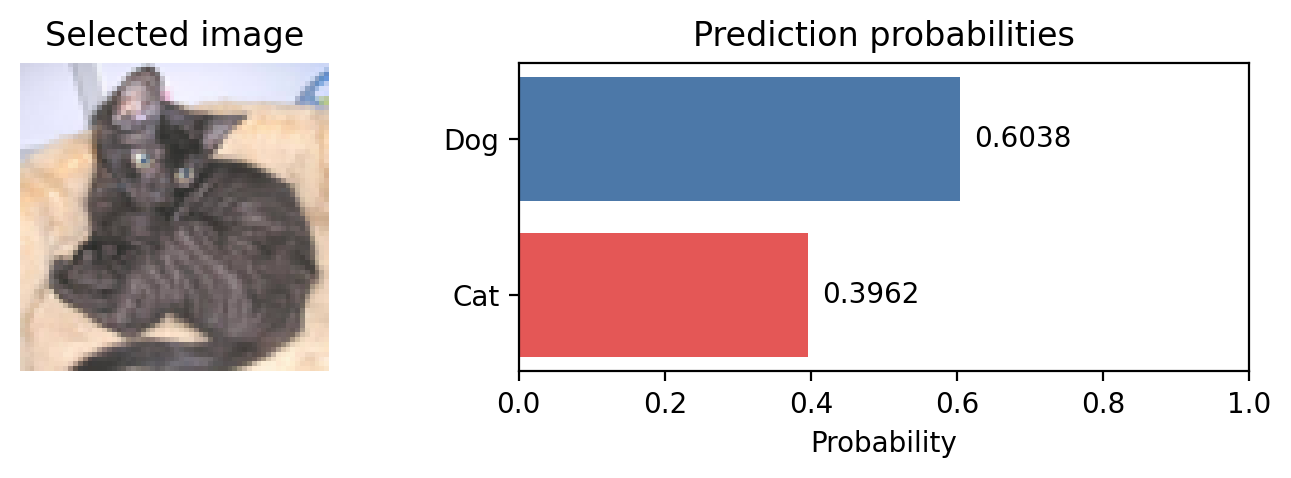

In [ ]:
_ = sample_button.value

if source_selector.value == "Test set":
    _pool_imgs, _pool_labels = test_images, test_labels
else:
    _pool_imgs, _pool_labels = train_images, train_labels

_idx = random.randint(0, len(_pool_imgs) - 1)
_image = _pool_imgs[_idx]
_true_label = int(_pool_labels[_idx])

_probs = predict(model, _image)
_predicted = int(_probs.argmax())

_chart, _caption = plot_prediction(
    _image, _probs, _true_label, _predicted, LABEL_NAMES
)
mo.vstack([_chart, mo.md(_caption)])

## How it works

- Real cat and dog photos are downloaded from a public GitHub dataset.
- Each image is resized to **64x64** RGB pixels and flattened into a
  **12,288**-dimensional feature vector (64 x 64 x 3 channels).
- **Logistic regression** is implemented as a single `nn.Linear` layer
  (12,288 -> 2) trained with SGD and cross-entropy loss in PyTorch.
- `torch.softmax` converts the raw logits into a probability distribution
  over the two classes.
- Click **Sample random image** to cycle through examples and inspect the
  model's confidence on each prediction.
- Because this is a linear model on raw pixels, accuracy is limited. More
  powerful approaches (CNNs, transfer learning) would perform significantly
  better on this task.

In [ ]:
def download_dataset(data_dir):
    if not data_dir.exists():
        subprocess.run(
            [
                "git",
                "clone",
                "--depth",
                "1",
                "https://github.com/laxmimerit/dog-cat-full-dataset.git",
            ],
            check=True,
        )

In [ ]:
@mo.persistent_cache
def load_dataset(data_dir, img_size, train_per_class, test_per_class):
    def _load(folder, label, n):
        paths = sorted(folder.glob("*.jpg"))[:n]
        imgs, labels = [], []
        for p in paths:
            img = Image.open(p).convert("RGB").resize((img_size, img_size))
            imgs.append(np.array(img, dtype=np.float32) / 255.0)
            labels.append(label)
        return imgs, labels

    train_cat, y_cat = _load(data_dir / "train" / "cats", 0, train_per_class)
    train_dog, y_dog = _load(data_dir / "train" / "dogs", 1, train_per_class)
    test_cat, yt_cat = _load(data_dir / "test" / "cats", 0, test_per_class)
    test_dog, yt_dog = _load(data_dir / "test" / "dogs", 1, test_per_class)
    return (
        np.array(train_cat + train_dog),
        np.array(y_cat + y_dog),
        np.array(test_cat + test_dog),
        np.array(yt_cat + yt_dog),
    )

In [ ]:
@mo.persistent_cache
def train_model(
    X_train, y_train, num_epochs=100, batch_size=64, lr=1e-3, weight_decay=1e-2
):
    X = torch.tensor(X_train.reshape(len(X_train), -1))
    y = torch.tensor(y_train, dtype=torch.long)

    model = nn.Linear(X.shape[1], 2)
    optimizer = torch.optim.SGD(
        model.parameters(), lr=lr, weight_decay=weight_decay
    )
    loss_fn = nn.CrossEntropyLoss()

    for epoch in range(num_epochs):
        model.train()
        perm = torch.randperm(len(X))
        for i in range(0, len(X), batch_size):
            idx = perm[i : i + batch_size]
            loss = loss_fn(model(X[idx]), y[idx])
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

    model.eval()
    return model

In [ ]:
def evaluate(model, images, labels):
    X = torch.tensor(images.reshape(len(images), -1))
    y = torch.tensor(labels, dtype=torch.long)
    with torch.no_grad():
        return (model(X).argmax(1) == y).float().mean().item()

In [ ]:
def predict(model, image):
    flat = torch.tensor(image.reshape(1, -1))
    with torch.no_grad():
        return torch.softmax(model(flat), dim=1)[0]

In [ ]:
def img_to_data_uri(img_array):
    img_uint8 = (img_array * 255).astype(np.uint8)
    pil_img = Image.fromarray(img_uint8)
    buf = io.BytesIO()
    pil_img.save(buf, format="PNG")
    b64 = base64.b64encode(buf.getvalue()).decode()
    return f"data:image/png;base64,{b64}"

In [ ]:
def plot_prediction(image, probs, true_label, predicted_label, label_names):
    prob_vals = [float(probs[0]), float(probs[1])]
    colors = ["#e45756", "#4c78a8"]

    fig, axes = plt.subplots(
        1, 2, figsize=(7, 2.5), gridspec_kw={"width_ratios": [1, 1.5]}
    )
    axes[0].imshow(image)
    axes[0].set_title("Selected image")
    axes[0].axis("off")

    axes[1].barh(["Cat", "Dog"], prob_vals, color=colors)
    axes[1].set_xlim(0, 1)
    axes[1].set_xlabel("Probability")
    axes[1].set_title("Prediction probabilities")
    for i, v in enumerate(prob_vals):
        axes[1].text(v + 0.02, i, f"{v:.4f}", va="center")
    fig.tight_layout()

    correct = predicted_label == true_label
    status = "Correct" if correct else "Incorrect"
    status_color = "green" if correct else "red"
    caption = (
        f"**True label:** {label_names[true_label]} | "
        f"**Predicted:** {label_names[predicted_label]} | "
        f"<span style='color:{status_color}'><b>{status}</b></span>"
    )
    return plt.gca(), caption